# Phase 1: Circuit Discovery for Chain-of-Thought Reasoning

**Colab-Native Implementation** | [GitHub](https://github.com/ashioyajotham/cot-faithfulness-mech-interp)

This notebook applies mechanistic interpretability techniques to reverse-engineer the computational circuits underlying chain-of-thought (CoT) reasoning in GPT-2 Small.

## What We'll Do
1. **Load GPT-2** via TransformerLens with activation hooks
2. **Generate reasoning examples** (arithmetic, logic, physics)
3. **Cache activations** during forward passes
4. **Build attribution graphs** mapping information flow
5. **Run causal ablations** to identify critical circuit components
6. **Visualize** attention patterns and circuit structure

---

## 1. Setup & Dependencies

In [ ]:
# Install dependencies (run once, then RESTART RUNTIME)
!pip install transformer-lens==2.0.0 torch matplotlib networkx einops jaxtyping -q

In [ ]:
# Install dependencies (run once)
#!pip install transformer-lens torch numpy matplotlib networkx plotly einops jaxtyping -q

import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# GPU Check
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"✅ GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ Running on CPU - this will be slow")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

✅ GPU: Tesla T4
   Memory: 15.8 GB


## 2. Load Model

In [ ]:
from transformer_lens import HookedTransformer

# Load GPT-2 Small (124M params)
model = HookedTransformer.from_pretrained(
    "gpt2",
    device=device,
    fold_ln=False,           # Keep layer norms separate for cleaner analysis
    center_writing_weights=False,
    center_unembed=False
)
model.eval()

print(f"\n✅ Model loaded: {model.cfg.model_name}")
print(f"   Layers: {model.cfg.n_layers}")
print(f"   Heads per layer: {model.cfg.n_heads}")
print(f"   Hidden dim: {model.cfg.d_model}")
print(f"   Vocab size: {model.cfg.d_vocab}")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer

✅ Model loaded: gpt2
   Layers: 12
   Heads per layer: 12
   Hidden dim: 768
   Vocab size: 50257


## 3. Reasoning Task Generation

We create prompts that elicit chain-of-thought reasoning across three domains:
- **Arithmetic**: Multi-step calculations
- **Logic**: Transitive reasoning
- **Physics**: Qualitative reasoning about physical systems

In [ ]:
@dataclass
class ReasoningTask:
    """A reasoning task with prompt and expected answer."""
    prompt: str
    task_type: str
    expected_answer: Optional[str] = None

def generate_arithmetic_task() -> ReasoningTask:
    """Generate a simple arithmetic reasoning task."""
    a, b = np.random.randint(10, 50, size=2)
    prompt = f"""Question: What is {a} + {b}?
Let me think step by step.
First, I'll add the ones place: {a % 10} + {b % 10} = {(a % 10) + (b % 10)}.
Then, I'll add the tens place: {a // 10} + {b // 10} = {(a // 10) + (b // 10)}.
Combining these, the answer is"""
    return ReasoningTask(prompt=prompt, task_type="arithmetic", expected_answer=str(a + b))

def generate_logic_task() -> ReasoningTask:
    """Generate a transitive logic reasoning task."""
    names = ["Alice", "Bob", "Carol", "David", "Eve"]
    a, b, c = np.random.choice(names, size=3, replace=False)
    prompt = f"""Question: If {a} is taller than {b}, and {b} is taller than {c}, who is the tallest?
Let me reason through this.
{a} > {b} (given)
{b} > {c} (given)
By transitivity, {a} > {b} > {c}.
Therefore, the tallest is"""
    return ReasoningTask(prompt=prompt, task_type="logic", expected_answer=a)

def generate_physics_task() -> ReasoningTask:
    """Generate a simple physics reasoning task."""
    height = np.random.randint(5, 20)
    prompt = f"""Question: A ball is dropped from {height} meters. Ignoring air resistance, will it speed up or slow down as it falls?
Let me think about this.
When an object falls, gravity pulls it downward.
Gravity provides constant acceleration of about 9.8 m/s².
Since acceleration is constant and positive, the speed will"""
    return ReasoningTask(prompt=prompt, task_type="physics", expected_answer="speed up")

# Generate sample tasks
tasks = [
    generate_arithmetic_task(),
    generate_logic_task(),
    generate_physics_task(),
    generate_arithmetic_task(),
]

print(f"Generated {len(tasks)} reasoning tasks:")
for i, task in enumerate(tasks, 1):
    print(f"\n--- Task {i} ({task.task_type}) ---")
    print(task.prompt[:200] + "...")

Generated 4 reasoning tasks:

--- Task 1 (arithmetic) ---
Question: What is 28 + 32?
Let me think step by step.
First, I'll add the ones place: 8 + 2 = 10.
Then, I'll add the tens place: 2 + 3 = 5.
Combining these, the answer is...

--- Task 2 (logic) ---
Question: If David is taller than Bob, and Bob is taller than Alice, who is the tallest?
Let me reason through this.
David > Bob (given)
Bob > Alice (given)
By transitivity, David > Bob > Alice.
There...

--- Task 3 (physics) ---
Question: A ball is dropped from 12 meters. Ignoring air resistance, will it speed up or slow down as it falls?
Let me think about this.
When an object falls, gravity pulls it downward.
Gravity provid...

--- Task 4 (arithmetic) ---
Question: What is 33 + 12?
Let me think step by step.
First, I'll add the ones place: 3 + 2 = 5.
Then, I'll add the tens place: 3 + 1 = 4.
Combining these, the answer is...


## 4. Generate Completions with Activation Caching

We run each prompt through the model and cache activations for analysis.

In [ ]:
@dataclass
class ReasoningExample:
    """A completed reasoning example with cached activations."""
    task: ReasoningTask
    full_text: str
    generated_text: str
    tokens: torch.Tensor
    cache: Dict

def generate_with_cache(task: ReasoningTask, max_new_tokens: int = 20) -> ReasoningExample:
    """Generate completion and cache activations (memory-efficient)."""
    # Tokenize prompt
    tokens = model.to_tokens(task.prompt)

    # Generate completion (without caching during generation for memory efficiency)
    with torch.no_grad():
        generated_tokens = model.generate(
            tokens,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos=True
        )

    # Run one final forward pass with caching on the full sequence
    with torch.no_grad():
        _, cache = model.run_with_cache(
            generated_tokens,
            names_filter=lambda name: any(x in name for x in [
                "hook_attn_out",      # Attention output
                "hook_mlp_out",       # MLP output
                "attn.hook_pattern",  # Attention patterns
                "hook_resid_post"     # Residual stream
            ])
        )

    # Decode text
    full_text = model.to_string(generated_tokens[0])
    generated_text = full_text[len(task.prompt):]

    return ReasoningExample(
        task=task,
        full_text=full_text,
        generated_text=generated_text,
        tokens=generated_tokens,
        cache=cache
    )

# Generate examples
print("Generating reasoning examples with activation caching...\n")
examples = []
for i, task in enumerate(tasks, 1):
    print(f"Task {i}/{len(tasks)}: {task.task_type}...", end=" ")
    example = generate_with_cache(task)
    examples.append(example)
    print(f"✓ Generated {len(example.generated_text)} chars")

print(f"\n✅ Generated {len(examples)} examples with cached activations")

Generating reasoning examples with activation caching...

Task 1/4: arithmetic... 

  0%|          | 0/20 [00:00<?, ?it/s]

✓ Generated 77 chars
Task 2/4: logic... 

  0%|          | 0/20 [00:00<?, ?it/s]

✓ Generated 73 chars
Task 3/4: physics... 

  0%|          | 0/20 [00:00<?, ?it/s]

✓ Generated 79 chars
Task 4/4: arithmetic... 

  0%|          | 0/20 [00:00<?, ?it/s]

✓ Generated 63 chars

✅ Generated 4 examples with cached activations


In [ ]:
# Show a sample completion
print("=" * 60)
print("SAMPLE COMPLETION")
print("=" * 60)
ex = examples[0]
print(f"Task Type: {ex.task.task_type}")
print(f"Expected: {ex.task.expected_answer}")
print(f"\nFull Text:\n{ex.full_text}")
print(f"\nCache Keys: {list(ex.cache.keys())[:5]}...")

SAMPLE COMPLETION
Task Type: arithmetic
Expected: 60

Full Text:
<|endoftext|>Question: What is 28 + 32?
Let me think step by step.
First, I'll add the ones place: 8 + 2 = 10.
Then, I'll add the tens place: 2 + 3 = 5.
Combining these, the answer is 8 + 2 = 10.
In this example, the tens place is called 32 + 32 =

Cache Keys: ['blocks.0.attn.hook_pattern', 'blocks.0.hook_attn_out', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.attn.hook_pattern']...


## 5. Attribution Graph Construction

We build a directed graph where:
- **Nodes** = attention heads and MLP layers
- **Edges** = information flow weighted by activation magnitude

In [ ]:
@dataclass
class CircuitNode:
    """A node in the circuit graph."""
    node_id: str
    layer: int
    component_type: str  # "attn", "mlp", "embed", "output"
    head_idx: Optional[int] = None
    activation_norm: float = 0.0

def build_attribution_graph(example: ReasoningExample, threshold: float = 0.1) -> nx.DiGraph:
    """
    Build attribution graph from cached activations.

    Nodes: Attention heads and MLP layers
    Edges: Weighted by activation magnitude (approximating information flow)
    """
    G = nx.DiGraph()
    cache = example.cache
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads

    # Add embedding node
    G.add_node("embed", layer=-1, component_type="embed", activation_norm=1.0)

    # Process each layer
    for layer in range(n_layers):
        # Get attention output for this layer
        attn_key = f"blocks.{layer}.hook_attn_out"
        mlp_key = f"blocks.{layer}.hook_mlp_out"

        if attn_key in cache:
            attn_out = cache[attn_key]  # [batch, seq, d_model]
            attn_norm = attn_out.norm(dim=-1).mean().item()

            # Add attention head nodes (using mean activation as proxy)
            # In reality, we'd decompose by head, but this is simplified
            for head in range(n_heads):
                node_id = f"L{layer}H{head}"
                head_norm = attn_norm / n_heads  # Approximate
                G.add_node(node_id, layer=layer, component_type="attn",
                          head_idx=head, activation_norm=head_norm)

        if mlp_key in cache:
            mlp_out = cache[mlp_key]
            mlp_norm = mlp_out.norm(dim=-1).mean().item()
            node_id = f"L{layer}MLP"
            G.add_node(node_id, layer=layer, component_type="mlp", activation_norm=mlp_norm)

    # Add output node
    G.add_node("output", layer=n_layers, component_type="output", activation_norm=1.0)

    # Build edges based on layer adjacency and activation strength
    nodes_by_layer = {}
    for node, data in G.nodes(data=True):
        layer = data.get('layer', -1)
        if layer not in nodes_by_layer:
            nodes_by_layer[layer] = []
        nodes_by_layer[layer].append((node, data))

    # Connect adjacent layers
    layers = sorted(nodes_by_layer.keys())
    for i in range(len(layers) - 1):
        src_layer = layers[i]
        dst_layer = layers[i + 1]

        for src_node, src_data in nodes_by_layer[src_layer]:
            for dst_node, dst_data in nodes_by_layer[dst_layer]:
                # Weight edge by destination activation (information received)
                weight = dst_data.get('activation_norm', 0.1)
                if weight > threshold:
                    G.add_edge(src_node, dst_node, weight=weight)

    return G

# Build graphs for all examples
graphs = []
for i, example in enumerate(examples, 1):
    print(f"Building graph {i}/{len(examples)}...", end=" ")
    G = build_attribution_graph(example)
    graphs.append(G)
    print(f"✓ {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print(f"\n✅ Built {len(graphs)} attribution graphs")

Building graph 1/4... ✓ 158 nodes, 1885 edges
Building graph 2/4... ✓ 158 nodes, 1885 edges
Building graph 3/4... ✓ 158 nodes, 1885 edges
Building graph 4/4... ✓ 158 nodes, 1885 edges

✅ Built 4 attribution graphs


In [ ]:
# Analyze graph statistics
G = graphs[0]
print("=" * 40)
print("ATTRIBUTION GRAPH STATISTICS")
print("=" * 40)
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# Count by component type
type_counts = {}
for _, data in G.nodes(data=True):
    t = data.get('component_type', 'unknown')
    type_counts[t] = type_counts.get(t, 0) + 1
print(f"\nBy Component Type: {type_counts}")

# Edge weight statistics
weights = [d['weight'] for _, _, d in G.edges(data=True)]
if weights:
    print(f"\nEdge Weights:")
    print(f"  Mean: {np.mean(weights):.3f}")
    print(f"  Std:  {np.std(weights):.3f}")
    print(f"  Max:  {np.max(weights):.3f}")

ATTRIBUTION GRAPH STATISTICS
Nodes: 158
Edges: 1885

By Component Type: {'embed': 1, 'attn': 144, 'mlp': 12, 'output': 1}

Edge Weights:
  Mean: 6.111
  Std:  12.199
  Max:  79.867


## 6. Causal Ablation Analysis

We systematically ablate (zero out) individual attention heads and MLP layers to identify which components are causally necessary for correct reasoning.

In [ ]:
def get_baseline_loss(tokens: torch.Tensor) -> float:
    """Get cross-entropy loss without any ablation."""
    with torch.no_grad():
        logits = model(tokens)
        # Loss on last token prediction
        loss = torch.nn.functional.cross_entropy(
            logits[0, -2, :],  # Predict last token from second-to-last
            tokens[0, -1]
        )
    return loss.item()

def ablate_attention_head(tokens: torch.Tensor, layer: int, head: int) -> float:
    """Ablate a specific attention head and measure effect on loss."""
    def head_ablation_hook(pattern, hook):
        # Zero out the attention pattern for this head
        pattern[:, head, :, :] = 0
        return pattern

    hook_name = f"blocks.{layer}.attn.hook_pattern"

    with torch.no_grad():
        logits = model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_name, head_ablation_hook)]
        )
        loss = torch.nn.functional.cross_entropy(
            logits[0, -2, :],
            tokens[0, -1]
        )
    return loss.item()

def ablate_mlp_layer(tokens: torch.Tensor, layer: int) -> float:
    """Ablate an entire MLP layer and measure effect on loss."""
    def mlp_ablation_hook(mlp_out, hook):
        return torch.zeros_like(mlp_out)

    hook_name = f"blocks.{layer}.hook_mlp_out"

    with torch.no_grad():
        logits = model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_name, mlp_ablation_hook)]
        )
        loss = torch.nn.functional.cross_entropy(
            logits[0, -2, :],
            tokens[0, -1]
        )
    return loss.item()

In [ ]:
# Run ablation study on first example
example = examples[0]
tokens = example.tokens

print("Running causal ablation study...\n")

# Baseline
baseline_loss = get_baseline_loss(tokens)
print(f"Baseline loss: {baseline_loss:.4f}\n")

# Ablate attention heads
head_effects = {}
print("Ablating attention heads...")
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        ablated_loss = ablate_attention_head(tokens, layer, head)
        effect = ablated_loss - baseline_loss
        head_effects[f"L{layer}H{head}"] = effect

# Ablate MLP layers
mlp_effects = {}
print("Ablating MLP layers...")
for layer in range(model.cfg.n_layers):
    ablated_loss = ablate_mlp_layer(tokens, layer)
    effect = ablated_loss - baseline_loss
    mlp_effects[f"L{layer}MLP"] = effect

print("\n✅ Ablation study complete!")

Running causal ablation study...

Baseline loss: 1.0437

Ablating attention heads...
Ablating MLP layers...

✅ Ablation study complete!


In [ ]:
# Analyze ablation results
all_effects = {**head_effects, **mlp_effects}

# Sort by effect magnitude
sorted_effects = sorted(all_effects.items(), key=lambda x: abs(x[1]), reverse=True)

print("=" * 50)
print("TOP 15 MOST IMPORTANT COMPONENTS (by causal effect)")
print("=" * 50)
print(f"{'Component':<12} {'Effect':>10} {'Direction':<10}")
print("-" * 32)
for comp, effect in sorted_effects[:15]:
    direction = "↑ loss" if effect > 0 else "↓ loss"
    print(f"{comp:<12} {effect:>10.4f} {direction}")

print("\n💡 Positive effect = ablating hurts performance (component is important)")
print("   Negative effect = ablating helps performance (component may be harmful)")

TOP 15 MOST IMPORTANT COMPONENTS (by causal effect)
Component        Effect Direction 
--------------------------------
L4MLP            1.7928 ↑ loss
L0MLP            1.5660 ↑ loss
L1MLP            1.0435 ↑ loss
L2H3             0.8976 ↑ loss
L5H5             0.7795 ↑ loss
L5H0             0.7519 ↑ loss
L0H10           -0.6783 ↓ loss
L5MLP            0.6469 ↑ loss
L0H8             0.6391 ↑ loss
L0H1             0.5702 ↑ loss
L3H0            -0.5595 ↓ loss
L5H1            -0.5083 ↓ loss
L7H4            -0.4949 ↓ loss
L11H0            0.4643 ↑ loss
L1H10            0.4412 ↑ loss

💡 Positive effect = ablating hurts performance (component is important)
   Negative effect = ablating helps performance (component may be harmful)


## 7. Visualization

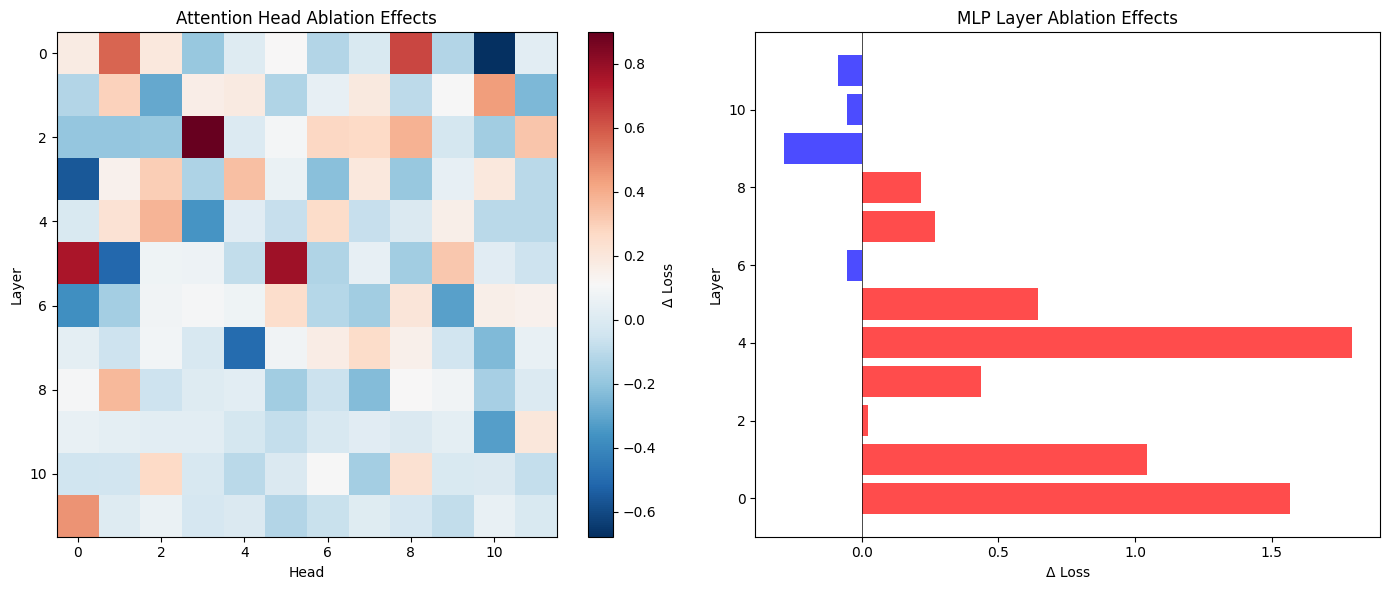


📊 Saved: ablation_effects.png


In [ ]:
# Plot ablation effects as heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Attention head effects heatmap
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_matrix = np.zeros((n_layers, n_heads))
for layer in range(n_layers):
    for head in range(n_heads):
        head_matrix[layer, head] = head_effects.get(f"L{layer}H{head}", 0)

im1 = axes[0].imshow(head_matrix, cmap='RdBu_r', aspect='auto')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
axes[0].set_title('Attention Head Ablation Effects')
plt.colorbar(im1, ax=axes[0], label='Δ Loss')

# MLP effects bar chart
mlp_layers = list(range(n_layers))
mlp_values = [mlp_effects.get(f"L{l}MLP", 0) for l in mlp_layers]
colors = ['red' if v > 0 else 'blue' for v in mlp_values]
axes[1].barh(mlp_layers, mlp_values, color=colors, alpha=0.7)
axes[1].set_xlabel('Δ Loss')
axes[1].set_ylabel('Layer')
axes[1].set_title('MLP Layer Ablation Effects')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('ablation_effects.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n📊 Saved: ablation_effects.png")

In [ ]:
# Visualize attention patterns for a key head
top_head = sorted_effects[0][0]  # Most important component

if top_head.startswith("L") and "H" in top_head and "MLP" not in top_head:
    # Parse layer and head
    parts = top_head.replace("L", "").split("H")
    layer, head = int(parts[0]), int(parts[1])

    # Get attention pattern
    pattern_key = f"blocks.{layer}.attn.hook_pattern"
    if pattern_key in example.cache:
        pattern = example.cache[pattern_key][0, head].cpu().numpy()  # [seq, seq]

        # Get tokens for labels
        token_strs = model.to_str_tokens(example.tokens[0])

        # Truncate if too long
        max_len = 30
        if len(token_strs) > max_len:
            pattern = pattern[:max_len, :max_len]
            token_strs = token_strs[:max_len]

        plt.figure(figsize=(12, 10))
        plt.imshow(pattern, cmap='Blues')
        plt.colorbar(label='Attention Weight')
        plt.xticks(range(len(token_strs)), token_strs, rotation=90, fontsize=8)
        plt.yticks(range(len(token_strs)), token_strs, fontsize=8)
        plt.xlabel('Key Position')
        plt.ylabel('Query Position')
        plt.title(f'Attention Pattern: {top_head} (Most Important Head)')
        plt.tight_layout()
        plt.savefig('attention_pattern.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n📊 Saved: attention_pattern.png")
else:
    print(f"Top component is {top_head} (not an attention head)")

Top component is L4MLP (not an attention head)


In [ ]:
# Draw circuit graph (simplified view)
G = graphs[0]

# Create a simplified graph with only high-effect nodes
important_nodes = [comp for comp, effect in sorted_effects[:20] if abs(effect) > 0.01]
important_nodes = [n for n in important_nodes if n in G.nodes()]

# Add connections
subgraph_nodes = set(important_nodes)
for node in important_nodes:
    # Add predecessors/successors within 1 hop
    subgraph_nodes.update(G.predecessors(node))
    subgraph_nodes.update(G.successors(node))

H = G.subgraph(subgraph_nodes)

plt.figure(figsize=(14, 10))

# Layout by layer
pos = {}
for node, data in H.nodes(data=True):
    layer = data.get('layer', 0)
    # Spread nodes horizontally within layer
    nodes_in_layer = [n for n, d in H.nodes(data=True) if d.get('layer', 0) == layer]
    idx = nodes_in_layer.index(node)
    pos[node] = (idx - len(nodes_in_layer)/2, -layer)

# Color by component type
colors = []
for node, data in H.nodes(data=True):
    if data.get('component_type') == 'attn':
        colors.append('#4CAF50' if node in important_nodes else '#A5D6A7')
    elif data.get('component_type') == 'mlp':
        colors.append('#2196F3' if node in important_nodes else '#90CAF9')
    else:
        colors.append('#9E9E9E')

nx.draw(H, pos, node_color=colors, with_labels=True, font_size=7,
        node_size=500, arrows=True, arrowsize=10, edge_color='#BDBDBD')

plt.title('Circuit Graph (Top 20 Important Components + Neighbors)')
plt.tight_layout()
plt.savefig('circuit_graph.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n📊 Saved: circuit_graph.png")

## 8. Summary & Key Findings

In [ ]:
print("=" * 60)
print("CIRCUIT DISCOVERY SUMMARY")
print("=" * 60)

# Find most important components
top_5 = sorted_effects[:5]
print("\n🔑 TOP 5 CRITICAL COMPONENTS:")
for i, (comp, effect) in enumerate(top_5, 1):
    print(f"   {i}. {comp}: Δ Loss = {effect:.4f}")

# Layer-level analysis
layer_importance = {}
for comp, effect in all_effects.items():
    layer = int(comp.split('L')[1].split('H')[0].split('M')[0])
    layer_importance[layer] = layer_importance.get(layer, 0) + abs(effect)

sorted_layers = sorted(layer_importance.items(), key=lambda x: x[1], reverse=True)
print("\n📊 MOST IMPORTANT LAYERS:")
for layer, importance in sorted_layers[:3]:
    print(f"   Layer {layer}: Total |effect| = {importance:.4f}")

# Attention vs MLP
attn_total = sum(abs(e) for c, e in all_effects.items() if 'H' in c and 'MLP' not in c)
mlp_total = sum(abs(e) for c, e in all_effects.items() if 'MLP' in c)
print(f"\n⚖️ COMPONENT TYPE COMPARISON:")
print(f"   Attention heads: {attn_total:.4f} total effect")
print(f"   MLP layers: {mlp_total:.4f} total effect")

print("\n" + "=" * 60)
print("✅ Phase 1 Complete!")
print("\n📁 Saved artifacts:")
print("   - ablation_effects.png")
print("   - attention_pattern.png")
print("   - circuit_graph.png")

---

## Next Steps

1. **Phase 2: Faithfulness Detection** - Train classifiers on circuit features to detect unfaithful reasoning
2. **Phase 3: Targeted Interventions** - Test circuit modifications to improve reasoning faithfulness
3. **Scale Analysis** - Extend to larger models (GPT-2 Medium/Large)

---

*Notebook by [Ashioya Jotham Victor](https://github.com/ashioyajotham)*